In [40]:
from gwpy.timeseries import TimeSeries

In [5]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import h5py

import os

In [41]:
#----------------------------------------------------------------
# Set parameters
#----------------------------------------------------------------
fn = 'data/H-H1_GWOSC_4KHZ_R1-1126257415-4096.hdf5' # data file
tevent = 1126259462.422 # Mon Sep 14 09:50:45 GMT 2015
evtname = 'GW150914' # event name

detector = 'H1' # detecotr: L1 or H1

In [42]:
#----------------------------------------------------------------
# Load LIGO data
#----------------------------------------------------------------
strain = TimeSeries.read(fn, format='hdf5.losc')
center = int(tevent)
strain = strain.crop(center-16, center+16)

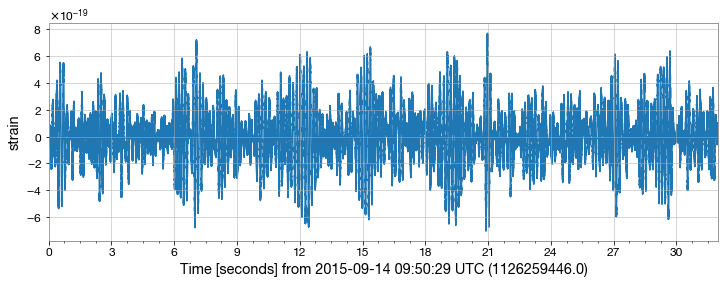

In [43]:
#----------------------------------------------------------------
# Show LIGO strain vs. time
#----------------------------------------------------------------
plt.figure()
strain.plot()
plt.ylabel('strain')
plt.show()

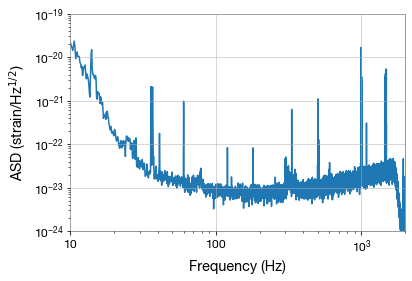

In [44]:
#----------------------------------------------------------------
# Obtain the power spectrum density PSD / ASD
#----------------------------------------------------------------

asd = strain.asd(fftlength=8)

plt.clf()
asd.plot()
plt.xlim(10, 2000)
plt.ylim(1e-24, 1e-19)
plt.ylabel('ASD (strain/Hz$^{1/2})$')
plt.xlabel('Frequency (Hz)')
plt.show()

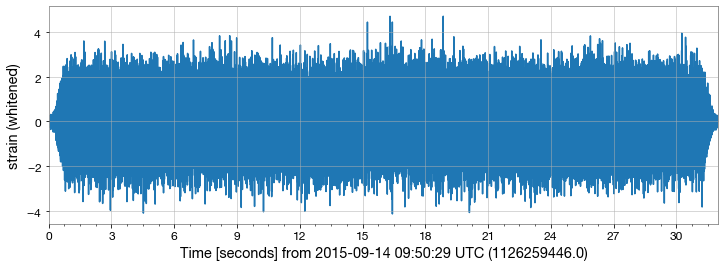

In [45]:
#----------------------------------------------------------------
# Whitening data
#----------------------------------------------------------------

white_data = strain.whiten()

plt.clf()
white_data.plot()
plt.ylabel('strain (whitened)')
plt.show()

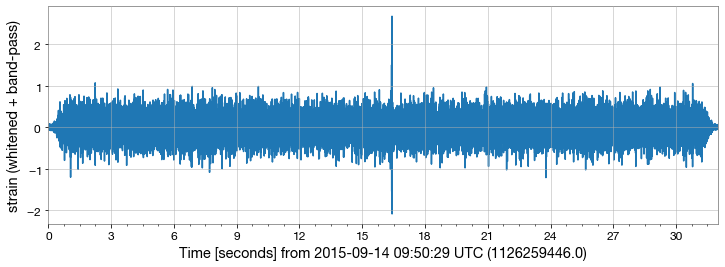

In [46]:
#----------------------------------------------------------------
# Bandpass filtering
#----------------------------------------------------------------

bandpass_low = 30
bandpass_high = 250

white_data_bp = white_data.bandpass(bandpass_low, bandpass_high)

plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.show()

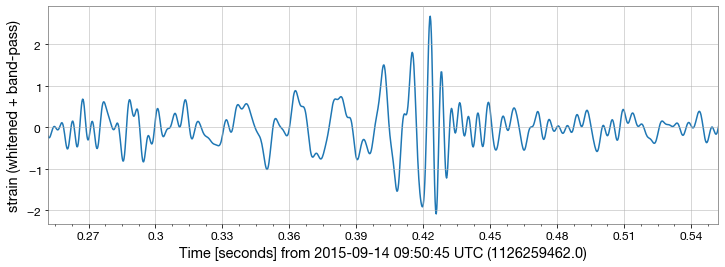

In [47]:
plt.clf()
white_data_bp.plot()
plt.ylabel('strain (whitened + band-pass)')
plt.xlim(tevent-0.17, tevent+0.13)
plt.show()

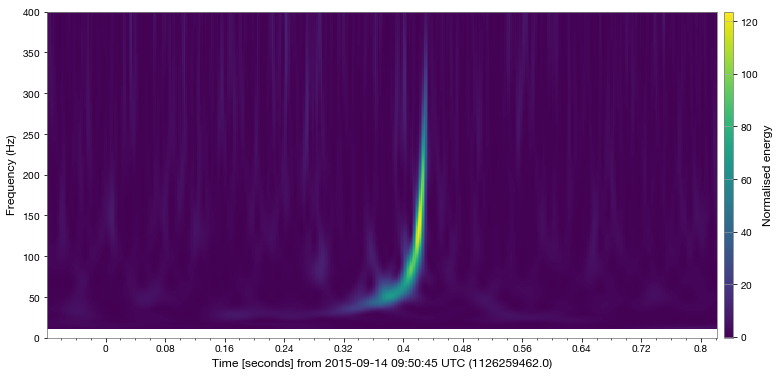

In [32]:
#----------------------------------------------------------------
# q-transform
#----------------------------------------------------------------

dt = 1  #-- Set width of q-transform plot, in seconds
hq = strain.q_transform(outseg=(tevent-dt, tevent+dt))

plt.clf()
fig = hq.plot()
ax = fig.gca()
fig.colorbar(label="Normalised energy")
ax.grid(False)
plt.xlim(tevent-0.5, tevent+0.4)
plt.ylim(0, 400)
plt.ylabel('Frequency (Hz)')
plt.show()

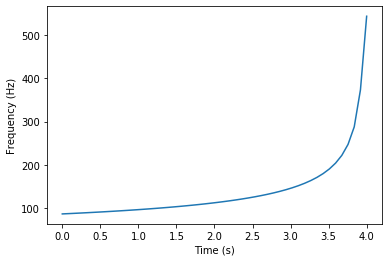

In [7]:
#----------------------------------------------------------------
# Frequency analytic
#----------------------------------------------------------------

def gwfreq(iM,iT,iT0):
    const = (948.5)*np.power((1./iM),5./8.)
    output = const*np.power(np.maximum((iT0-iT),3e-2),-3./8.) # we can max it out above 500 Hz-ish
    return output

times = np.linspace(0., 4., 50)
freq = gwfreq(20, times, 4)

plt.clf()
plt.plot(times, freq)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [1]:
import lmfit

In [36]:
def osc(t, Mc, t0, C, phi):
    return C * np.power(Mc * gwfreq(Mc, t, t0), 10/3) * np.cos(gwfreq(Mc, t, t0) * (t0-t) + phi) * np.power(1e-30, np.heaviside(t - t0, 0) * (t - t0))

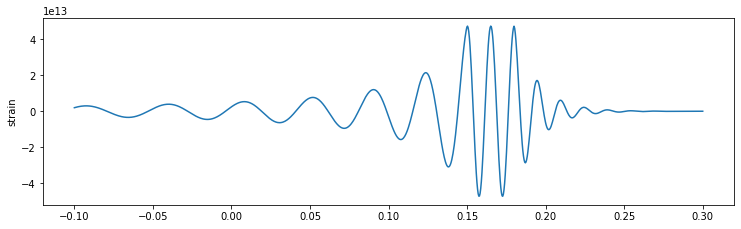

In [37]:
times = np.linspace(-0.1, 0.3, 1000)
freq = osc(times, 30, 0.18, 1, 0.0)
plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(times, freq)
#plt.xlabel('Time (s) since '+str(tevent))
plt.ylabel('strain')
plt.show()


In [38]:
def osc_dif(params, x, data, eps):
    iM=params["Mc"]
    iT0=params["t0"]
    norm=params["C"]
    phi=params["phi"]
    val=osc(x, iM, iT0, norm, phi)
    return (val-data)/eps

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 126
    # data points      = 1228
    # variables        = 4
    chi-square         = 0.52811295
    reduced chi-square = 4.3146e-04
    Akaike info crit   = -9510.94908
    Bayesian info crit = -9490.49651
[[Variables]]
    Mc:   18.4706672 +/- 0.17840377 (0.97%) (init = 20)
    t0:   0.17857277 +/- 5.0525e-04 (0.28%) (init = 0.18)
    C:   -3.8911e-14 +/- 1.5922e-15 (4.09%) (init = 1)
    phi: -0.51955712 +/- 0.30749525 (59.18%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(t0, phi) = -0.983
    C(Mc, phi) =  0.889
    C(Mc, t0)  = -0.827
    C(Mc, C)   =  0.305
    C(C, phi)  =  0.272
    C(t0, C)   = -0.253


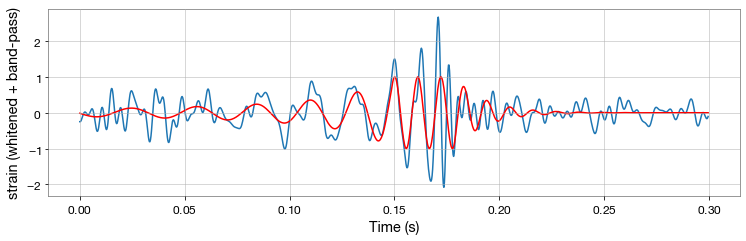

In [48]:
#----------------------------------------------------------------
# Fit
#----------------------------------------------------------------

sample_times = white_data_bp.times.value
sample_data = white_data_bp.value
indxt = np.where((sample_times >= (tevent-0.17)) & (sample_times < (tevent+0.13)))
x = sample_times[indxt]
x = x-x[0]
white_data_bp_zoom = sample_data[indxt]

plt.figure(figsize=(12, 4))
plt.subplots_adjust(left=0.1, right=0.9, top=0.85, bottom=0.2)
plt.plot(x, white_data_bp_zoom)
plt.xlabel('Time (s)')
plt.ylabel('strain (whitened + band-pass)')

import lmfit
from lmfit import Model, minimize, fit_report, Parameters

model = lmfit.Model(osc)
p = model.make_params()
p['Mc'].set(20)     # Mass guess
p['t0'].set(0.18)  # By construction we put the merger in the center
p['C'].set(1)      # normalization guess
p['phi'].set(0)    # Phase guess
unc = np.full(len(white_data_bp_zoom),20)
out = minimize(osc_dif, params=p, args=(x, white_data_bp_zoom, unc))
print(fit_report(out))
plt.plot(x, model.eval(params=out.params,t=x),'r',label='best fit')
plt.show()

In [ ]:
# load templates to get better fit for signal

In [ ]:
# write script to search for signal in large time block

## Other things to try
- Check and quantify the consistence between detectors (H1 and V1)
- Load the template database, fit the data, and get more accurate parameters
- Determine how far the source of GW is away
- Explore more events
- Data of other events can be found at https://www.gw-openscience.org/eventapi/html/allevents/
- How to determine if the source is black hole merger or neutron star merger or other source?